## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset de plusieurs profils dans le domaine de Data, on va:

- explorer les données 
- faire un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes



## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
 

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

### 1) Importer le tableau de données dans un dataframe 

In [3]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')
df.shape

(9582, 6)

In [4]:
df.dtypes

Entreprise      object
Metier          object
Technologies    object
Diplome         object
Experience      object
Ville           object
dtype: object

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [5]:
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [6]:
print('Il y a {} observations'.format(len(df)))

Il y a 9582 observations


In [7]:
vm=round(df.isnull().sum().sum()/len(df)*100,2)
print('Il y a environ {}% de valeurs manquantes'.format(vm))

Il y a environ 1.36% de valeurs manquantes


### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers


In [8]:
round(df.isnull().sum()/len(df)*100,2)

Entreprise      0.18
Metier          0.20
Technologies    0.00
Diplome         0.00
Experience      0.98
Ville           0.00
dtype: float64

Il faut d'abord convertir le type de la variable Experience de *string* à *float*. Pour le faire, on remplace les vergules par des points:

In [9]:
df.Experience=df.Experience.str.replace(',','.')

Ensuite on change le type de la variable Experience de string à float pour les valeurs non manquantes:

In [11]:
df['Experience'] = df['Experience'].astype(float)#[~df.Experience.isnull()]

Dans la suite on va traiter les données (remplacer, suprimer des lignes). Donc il vaut mieux garder une copie (type deep) avant ce traitement.

In [13]:
df_new=df.copy()

On crée la serie boléenne MDS pour differencier les Metiers Data Scientist

In [15]:
DS=df_new.Metier=='Data scientist'

On calcule la valeur médiane de L'experience pour les data scientists

In [16]:
MDS=round(df['Experience'][DS].median(),1)
MDS

2.0

On remplace les *NaNs* de l'experience des Data scientists par la mediane

In [18]:
df_new.loc[DS,'Experience']=df_new.loc[DS,'Experience'].fillna(MDS)

On fait pareil pour les Data Engineers, Lead data scientist et les Data architecte  en remlaçant la mediane par la moyenne

In [20]:
for M in list(filter(lambda x : x != 'Data scientist', df_new.Metier.dropna().unique())):
    #créer la serie boléenne pour differencier la Metier M
    DM=df_new.Metier==M
    #calculer la moyenne d'Experience correspondante
    MM=round(df['Experience'][DM].mean(),1)
    #Remplacer les nan
    df_new.loc[DM,'Experience']=df_new.loc[DM,'Experience'].fillna(MM)

On verifie qu'il ne reste plus des valeurs manquantes pour l'Experience

In [22]:
df_new.Experience.isnull().sum()

0

Concernant la variable Metier, les valeurs manquantes ne constituent que 0.2% de la base de données. Sachant que cette variable est la plus importante (variable cible), on va simplement suprimer les observations avec Metier inconnu:

In [24]:
df_new.dropna(subset=['Metier'],inplace=True)
df_new.Metier.isnull().sum()

0

Lavariable Entreprise depant essentiellement de la ville et des Metiers. Donc on remlace les valeurs manquante par l'entreprise la plus connue pour chaque Ville et chaque Metier:

In [25]:
t=df_new.groupby(['Ville','Metier']).apply(lambda x : x.Entreprise.value_counts().index[0])
df_new['Entreprise'] = df_new.apply(
    lambda r: t[r['Ville'],r['Metier']] if pd.isnull(r.Entreprise) else r['Entreprise'],axis=1)

On verifie qu'il ne reste plus de valeurs manquantes pour la metier

In [26]:
df_new.Entreprise.isnull().sum()

0

In [27]:
df_new.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux


### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?


In [28]:
df_Metier=df_new[['Metier','Experience']].groupby(['Metier']).mean()
df_Metier

,Experience
Metier,
Data architecte,3.000471
Data engineer,2.985087
Data scientist,2.241268
Lead data scientist,3.965798


### 5) Comparer le nombre moyen d'années d'expériences pour chaque métier

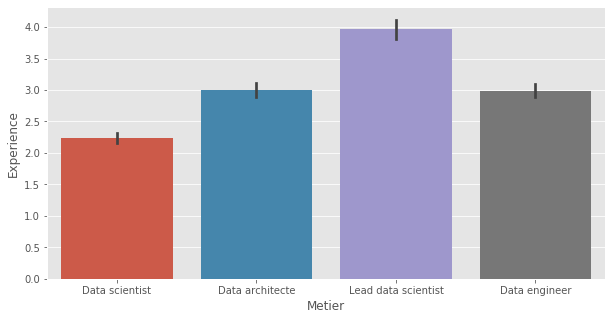

In [29]:
plt.figure(figsize=(10,5))
sb.barplot(x='Metier', y='Experience',data=df_new)

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert  

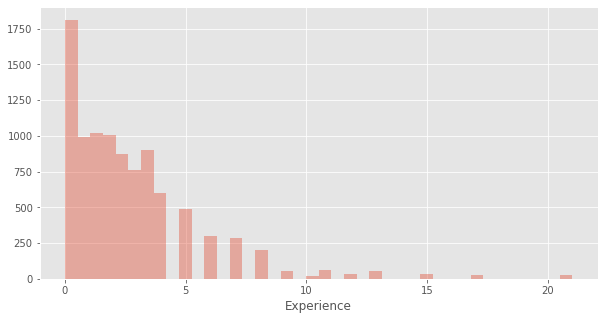

In [31]:
plt.figure(figsize=(10,5))
sb.distplot(df_new['Experience'], bins=40,kde=False)

Vue la distribution des années d'experience dans la figure ci dessous, on choisit la repartition suivante:
 * $0-2$ : débutant
 * $2-5$ : confirmé
 * $5-10$ : avancé 
 * $>10$ : expert

In [32]:
def convert(x):
    if x<2:
        return 'debutant'
    elif x<5:
        return 'confirme'
    elif x<10:
        return 'avance'
    else:
        return 'expert'
    
df_new['Exp_label'] = df_new['Experience'].apply(convert)

### 7) Quelles sont les 5 technologies les plus utilisées? 

* On commence par enlever la redondance dans la liste des technologies

In [33]:
def preprocess(text_string):
    parsed_text = re.sub(" ", "_", text_string)#pour les technologie composés de deux mots séparés par un espace
    parsed_text=parsed_text.lower()
    parsed_text = re.sub("(?:c/c\+\+|c\+\+)", "c", parsed_text)
    parsed_text = re.sub("/", " ", parsed_text)
    parsed_text = re.sub("-", "_", parsed_text)#pour les technologie composés de deux mots séparés par -
    parsed_text = re.sub("(?:mysql|nosql|nosq)", "sql", parsed_text)
    parsed_text = re.sub("(?:pyspark)", "spark", parsed_text)
    parsed_text = re.sub("(?:elasticsearch|kibana)", "elastic_kabina", parsed_text)
    return parsed_text


skills=df_new.Technologies.apply(preprocess).tolist()

In [34]:
#supprimer les doublants 
skills=[' '.join(list(dict.fromkeys(x.split(' ')))) for x in skills]

* Realiser a bag of words pour les technologies

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,token_pattern = r"(?u)\b\w+\b")
# tokenize and build vocab
vectorizer.fit(skills)
# summarize
print(vectorizer.vocabulary_.keys())
# encode document
vector = vectorizer.transform(skills)
# summarize encoded vector
print(vector.shape)

dict_keys(['matlab', 'python', 'spark', 'scikit_learn', 'tensorflow', 'java', 'scala', 'mongodb', 'spss', 'sql', 'teradata', 'r', 'c', 'numpy', 'vba', 'excel', 'linux', 'docker', 'gnu', 'hadoop', 'hive', 'mariadb', 'machine_learning', 'aws', 'deep_learning', 'postgresql', 'elastic_kabina', 'hdfs', 'yarn', 'microsoft_azure', 'redshift', 'sas', 'anglais', 'ai', 'scoring', 'perl', 'ruby', 'pycharm', 'vertica', 'tableau', 'big_data', 'kafka', 'oracle', 'cassandra', 'matplotlib', 'map_reduce', 'pig', 'hbase', 'windows'])
(9563, 49)


In [36]:
df_skills=pd.DataFrame(vector.toarray()[:,list(vectorizer.vocabulary_.values())],
             columns=list(vectorizer.vocabulary_.keys()))
df_skills.head()

,matlab,python,spark,scikit_learn,tensorflow,java,scala,mongodb,spss,sql,...,tableau,big_data,kafka,oracle,cassandra,matplotlib,map_reduce,pig,hbase,windows
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


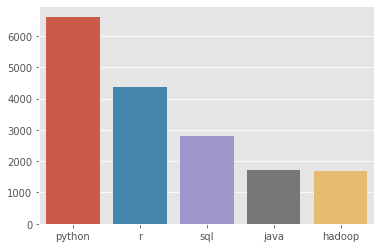

In [37]:
sb.barplot(x=df_skills.sum().sort_values(ascending=False).index[0:5],
           y=df_skills.sum().sort_values(ascending=False).values[0:5])

### 8) Réaliser une méthode de clustering non supervisée pour faire apparaître 2 clusters

* Supprimer les colonnes Entreprise et Ville, pour pouvoire faire un clustering basé seulement sur le profil techniques

In [39]:
df_new.Technologies=skills
df_cat=df_new.drop(['Experience','Entreprise','Ville'],axis=1)

In [40]:
df_cat.Metier=df_cat.Metier.str.replace(' ','_')

In [41]:
df_cat.head()

,Metier,Technologies,Diplome,Exp_label
0,Data_scientist,matlab python spark scikit_learn tensorflow,Master,debutant
1,Data_architecte,python java scala mongodb,Master,confirme
2,Lead_data_scientist,spss sql teradata r python tensorflow scikit_l...,Master,confirme
3,Data_scientist,c java python,Master,debutant
4,Data_scientist,matlab python c numpy tensorflow scikit_learn,Phd,confirme


* Calculer les coefficients tf-idf 

In [42]:
def agg1(x):
    r=''
    for col in df_cat.columns[0:-1]:
        r=r+x[col].lower()+' '
    return r+x[df_cat.columns[-1]].lower()

corpus=df_cat.apply(agg1,axis=1)
corpus.head()

0    data_scientist matlab python spark scikit_lear...
1    data_architecte python java scala mongodb mast...
2    lead_data_scientist spss sql teradata r python...
3         data_scientist c java python master debutant
4    data_scientist matlab python c numpy tensorflo...
dtype: object

In [43]:
tfidfvect= TfidfVectorizer(analyzer = "word",tokenizer = None,token_pattern = r"(?u)\b\w+\b")
# tokenize and build vocab
vect =tfidfvect.fit_transform(corpus)
# summarize
print(tfidfvect.vocabulary_.keys())
print(vect.shape)

dict_keys(['data_scientist', 'matlab', 'python', 'spark', 'scikit_learn', 'tensorflow', 'master', 'debutant', 'data_architecte', 'java', 'scala', 'mongodb', 'confirme', 'lead_data_scientist', 'spss', 'sql', 'teradata', 'r', 'c', 'numpy', 'phd', 'vba', 'excel', 'avance', 'bachelor', 'linux', 'docker', 'data_engineer', 'gnu', 'hadoop', 'hive', 'mariadb', 'machine_learning', 'aws', 'deep_learning', 'postgresql', 'elastic_kabina', 'no', 'diploma', 'hdfs', 'yarn', 'microsoft_azure', 'redshift', 'sas', 'anglais', 'ai', 'scoring', 'perl', 'ruby', 'pycharm', 'vertica', 'tableau', 'big_data', 'kafka', 'oracle', 'cassandra', 'expert', 'matplotlib', 'map_reduce', 'pig', 'hbase', 'windows'])
(9563, 62)


In [44]:
df_corpus=pd.DataFrame(vect.toarray()[:,list(tfidfvect.vocabulary_.values())],
             columns=list(tfidfvect.vocabulary_.keys()))
df_corpus.head()

,data_scientist,matlab,python,spark,scikit_learn,tensorflow,master,debutant,data_architecte,java,...,big_data,kafka,oracle,cassandra,expert,matplotlib,map_reduce,pig,hbase,windows
0,0.257077,0.458112,0.184664,0.371197,0.471450,0.461722,0.223409,0.258444,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.191953,0.000000,0.000000,0.000000,0.232228,0.000000,0.351204,0.380868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.151361,0.000000,0.386428,0.378454,0.183119,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.360663,0.000000,0.259073,0.000000,0.000000,0.000000,0.313430,0.362582,0.000000,0.514044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.205320,0.365881,0.147486,0.000000,0.376534,0.368764,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(vect)

Text(0.5, 1.0, 'Le nombre de occurence chaque metier pour chaque classe')

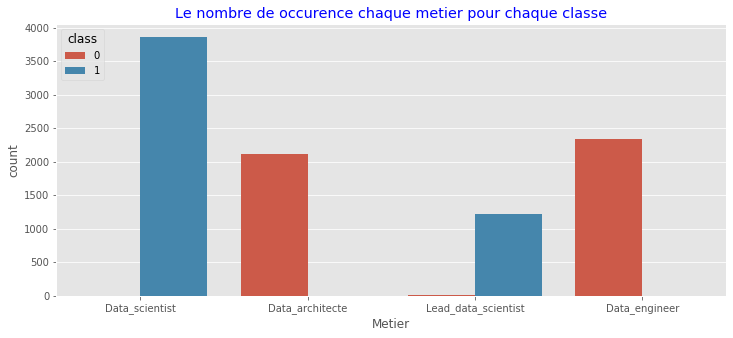

In [46]:
labels=kmeans.labels_

plt.figure(figsize=(12,5))
df_cat_class=df_cat.copy()
df_cat_class['class']=labels
sb.countplot(x="Metier", hue="class", data=df_cat_class)
plt.title('Le nombre de occurence chaque metier pour chaque classe',color='b')

Text(0.5, 1.0, 'Classe 1')

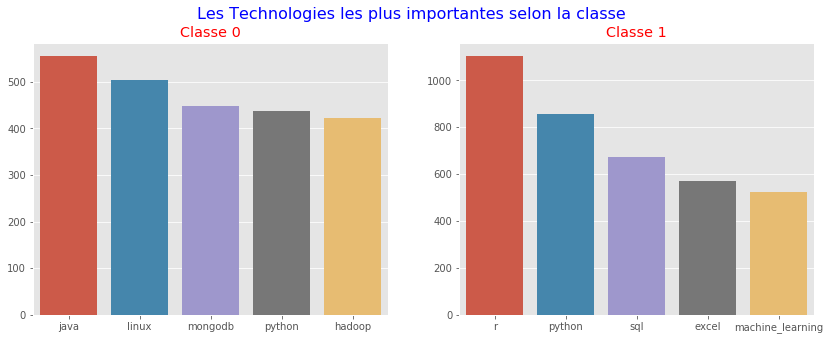

In [47]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
fig.suptitle('Les Technologies les plus importantes selon la classe',fontsize = 16,color='b')

sb.barplot(x=df_corpus[df_skills.columns].loc[labels==0].sum().sort_values(ascending=False).index[0:5],
           y=df_corpus[df_skills.columns].loc[labels==0].sum().sort_values(ascending=False).values[0:5],ax=ax[0])
ax[0].set_title('Classe 0',color='r')

sb.barplot(x=df_corpus[df_skills.columns].loc[labels==1].sum().sort_values(ascending=False).index[0:5],
           y=df_corpus[df_skills.columns].loc[labels==1].sum().sort_values(ascending=False).values[0:5],ax=ax[1])
ax[1].set_title('Classe 1',color='r')

On remarque que les data_scientists et lead_data_scientists forment une classe telque les technologies les plus importantes sont les suivant: R, Python, Sql, Excel et Machine learning.
La 2éme classe est constituée par les data_architectes et les data_engineers telque Java, Linux, mongodb, python et hadoop sont les technologies les plus importantes.